# 영화 리뷰 감정 분석
**RNN 을 이용해 IMDB 데이터를 가지고 텍스트 감정분석.**

이번 책에서 처음으로 접하는 텍스트 형태의 데이터셋인 IMDB 데이터셋은 50,000건의 영화 리뷰로 이루어져 있습니다.
각 리뷰는 다수의 영어 문장들로 이루어져 있으며, 평점이 7점 이상의 긍정적인 영화 리뷰는 2로, 평점이 4점 이하인 부정적인 영화 리뷰는 1로 레이블링 되어 있습니다. 영화 리뷰 텍스트를 RNN 에 입력시켜 영화평의 전체 내용을 압축하고, 이렇게 압축된 리뷰가 긍정적인지 부정적인지 판단해주는 간단한 분류 모델을 만드는 것이 이번 프로젝트의 목표입니다.

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext import data, datasets

In [2]:
# 하이퍼파라미터
BATCH_SIZE = 64
lr = 0.001
EPOCHS = 10
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("다음 기기로 학습합니다:", DEVICE)

다음 기기로 학습합니다: cuda


In [3]:
# 데이터 로딩하기
print("데이터 로딩중...")
TEXT = data.Field(sequential=True, batch_first=True, lower=True)
LABEL = data.Field(sequential=False, batch_first=True) # 첫번째 차원 값이 batch_size가 되는 batch_first
trainset, testset = datasets.IMDB.splits(TEXT, LABEL)
TEXT.build_vocab(trainset, min_freq=5) # 최소 5번 이상 등장한 단어만 사전에, 미만은 'unk'
LABEL.build_vocab(trainset)

# 학습용 데이터를 학습셋 80% 검증셋 20% 로 나누기
trainset, valset = trainset.split(split_ratio=0.8)

# batch 단위로 쪼개기
train_iter, val_iter, test_iter = data.BucketIterator.splits(
        (trainset, valset, testset), batch_size=BATCH_SIZE,
        shuffle=True, repeat=False)


vocab_size = len(TEXT.vocab)
n_classes = 2 # 긍/부정

데이터 로딩중...


In [4]:
print("[학습셋]: %d [검증셋]: %d [테스트셋]: %d [단어수]: %d [클래스] %d"
      % (len(trainset),len(valset), len(testset), vocab_size, n_classes))

[학습셋]: 20000 [검증셋]: 5000 [테스트셋]: 25000 [단어수]: 46159 [클래스] 2


In [5]:
class BasicGRU(nn.Module):
    def __init__(self, n_layers, hidden_dim, n_vocab, embed_dim, n_classes, dropout_p=0.2):
        super(BasicGRU, self).__init__()
        print("Building Basic GRU model...")
        self.n_layers = n_layers # 은닉 벡터의 개수
        self.embed = nn.Embedding(n_vocab, embed_dim) # 사전의 단어수, 임베딩 단어의 차원 수
        self.hidden_dim = hidden_dim # 은닉 벡터의 차원
        self.dropout = nn.Dropout(dropout_p)
        self.gru = nn.GRU(embed_dim, self.hidden_dim,
                          num_layers=self.n_layers,
                          batch_first=True)
        self.out = nn.Linear(self.hidden_dim, n_classes)

    def forward(self, x): # 오버라이딩되면서 자동 실행
        x = self.embed(x)
        h_0 = self._init_state(batch_size=x.size(0))
        x, _ = self.gru(x, h_0)  # [batch_size, 입력 x의 길이, hidden_dim]
        h_t = x[:,-1,:]
        self.dropout(h_t)
        logit = self.out(h_t)  # [b, h] -> [b, o]
        return logit
    
    def _init_state(self, batch_size=1):
        weight = next(self.parameters()).data
        return weight.new(self.n_layers, batch_size, self.hidden_dim).zero_()


In [6]:
def train(model, optimizer, train_iter):
    model.train()
    for b, batch in enumerate(train_iter):
        x, y = batch.text.to(DEVICE), batch.label.to(DEVICE)
        y.data.sub_(1)  # 레이블 값을 0과 1로 변환(1씩 빼기)
        optimizer.zero_grad()

        logit = model(x)
        loss = F.cross_entropy(logit, y)
        loss.backward()
        optimizer.step()

In [7]:
def evaluate(model, val_iter):
    """evaluate model"""
    model.eval()
    corrects, total_loss = 0, 0
    for batch in val_iter:
        x, y = batch.text.to(DEVICE), batch.label.to(DEVICE)
        y.data.sub_(1) # 레이블 값을 0과 1로 변환
        logit = model(x)
        loss = F.cross_entropy(logit, y, reduction='sum')
        total_loss += loss.item()
        corrects += (logit.max(1)[1].view(y.size()).data == y.data).sum()
    size = len(val_iter.dataset)
    avg_loss = total_loss / size
    avg_accuracy = 100.0 * corrects / size
    return avg_loss, avg_accuracy

In [8]:
model = BasicGRU(1, 256, vocab_size, 128, n_classes, 0.5).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# 어떤 최적화 알고리즘을 쓸지 모를때는 Adam으로!

Building Basic GRU model...
BasicGRU(
  (embed): Embedding(46159, 128)
  (dropout): Dropout(p=0.5)
  (gru): GRU(128, 256, batch_first=True)
  (out): Linear(in_features=256, out_features=2, bias=True)
)


In [9]:
best_val_loss = None
for e in range(1, EPOCHS+1):
    train(model, optimizer, train_iter)
    val_loss, val_accuracy = evaluate(model, val_iter)

    print("[이폭: %d] 검증 오차:%5.2f | 검증 정확도:%5.2f" % (e, val_loss, val_accuracy))
    
    # 검증 오차가 가장 적은 최적의 모델을 저장
    if not best_val_loss or val_loss < best_val_loss:
        if not os.path.isdir("snapshot"):
            os.makedirs("snapshot")
        torch.save(model.state_dict(), './snapshot/txtclassification.pt')
        best_val_loss = val_loss

[이폭: 1] 검증 오차: 0.69 | 검증 정확도:49.00
[이폭: 2] 검증 오차: 0.69 | 검증 정확도:50.00
[이폭: 3] 검증 오차: 0.69 | 검증 정확도:54.00
[이폭: 4] 검증 오차: 0.70 | 검증 정확도:50.00
[이폭: 5] 검증 오차: 0.40 | 검증 정확도:81.00
[이폭: 6] 검증 오차: 0.33 | 검증 정확도:86.00
[이폭: 7] 검증 오차: 0.35 | 검증 정확도:85.00
[이폭: 8] 검증 오차: 0.36 | 검증 정확도:86.00
[이폭: 9] 검증 오차: 0.38 | 검증 정확도:86.00
[이폭: 10] 검증 오차: 0.41 | 검증 정확도:86.00


In [10]:
model.load_state_dict(torch.load('./snapshot/txtclassification.pt'))
test_loss, test_acc = evaluate(model, test_iter)
print('테스트 오차: %5.2f | 테스트 정확도: %5.2f' % (test_loss, test_acc))

테스트 오차:  0.31 | 테스트 정확도: 86.00


# Seq2Seq 기계번역
- "hello"를 "hola"로 바꾸는 Mini Seq2Seq

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt

In [2]:
vocab_size = 256  # 총 아스키 코드 개수
x_ = list(map(ord, "hello"))  # 아스키 코드 리스트로 변환
y_ = list(map(ord, "hola"))   # 아스키 코드 리스트로 변환
print("hello -> ", x_)
print("hola  -> ", y_)

hello ->  [104, 101, 108, 108, 111]
hola  ->  [104, 111, 108, 97]


In [3]:
x = torch.LongTensor(x_)
y = torch.LongTensor(y_)

In [4]:
class Seq2Seq(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super(Seq2Seq, self).__init__()
        self.n_layers = 1
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, hidden_size) # 임베딩된 토큰의 차원값으로 설정
        self.encoder = nn.GRU(hidden_size, hidden_size) 
        self.decoder = nn.GRU(hidden_size, hidden_size)
        self.project = nn.Linear(hidden_size, vocab_size)

    def forward(self, inputs, targets):
        # 인코더에 들어갈 입력
        initial_state = self._init_state()
        embedding = self.embedding(inputs).unsqueeze(1) # 차원 추가
        # embedding = [seq_len, batch_size, embedding_size]
        
        # 인코더 (Encoder)
        encoder_output, encoder_state = self.encoder(embedding, initial_state)
        # encoder_output = [seq_len, batch_size, hidden_size]
        # encoder_state  = [n_layers, seq_len, hidden_size]

        # 디코더에 들어갈 입력
        decoder_state = encoder_state
        decoder_input = torch.LongTensor([0]) # 문장시작을 알리기 위한 '0'
        
        # 디코더 (Decoder)
        outputs = []
        
        for i in range(targets.size()[0]):
            decoder_input = self.embedding(decoder_input).unsqueeze(1)
            decoder_output, decoder_state = self.decoder(decoder_input, decoder_state)
            projection = self.project(decoder_output) # 디코더의 출력값으로 다음 글자 예측
            outputs.append(projection)
            
            #티처 포싱(Teacher Forcing) 사용
            decoder_input = torch.LongTensor([targets[i]])

        outputs = torch.stack(outputs).squeeze()
        return outputs
    
    def _init_state(self, batch_size=1):
        weight = next(self.parameters()).data
        return weight.new(self.n_layers, batch_size, self.hidden_size).zero_()

In [5]:
seq2seq = Seq2Seq(vocab_size, 16)

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(seq2seq.parameters(), lr=1e-3)

In [7]:
log = []
for i in range(1000):
    prediction = seq2seq(x, y)
    loss = criterion(prediction, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_val = loss.data
    log.append(loss_val)
    if i % 100 == 0:
        print("\n 반복:%d 오차: %s" % (i, loss_val.item()))
        _, top1 = prediction.data.topk(1, 1)
        print([chr(c) for c in top1.squeeze().numpy().tolist()])


 반복:0 오차: 5.675046920776367
['\x1f', '\r', ',', '\x9f']

 반복:100 오차: 2.0893044471740723
['h', 'o', 'l', 'l']

 반복:200 오차: 0.6163396239280701
['h', 'o', 'l', 'a']

 반복:300 오차: 0.29440271854400635
['h', 'o', 'l', 'a']

 반복:400 오차: 0.18808504939079285
['h', 'o', 'l', 'a']

 반복:500 오차: 0.1334923803806305
['h', 'o', 'l', 'a']

 반복:600 오차: 0.10067909955978394
['h', 'o', 'l', 'a']

 반복:700 오차: 0.07920406758785248
['h', 'o', 'l', 'a']

 반복:800 오차: 0.0642411857843399
['h', 'o', 'l', 'a']

 반복:900 오차: 0.05330570414662361
['h', 'o', 'l', 'a']


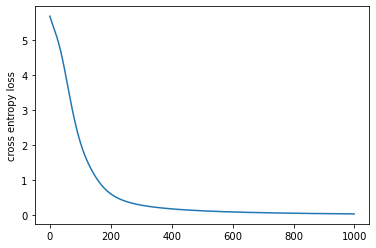

In [8]:
plt.plot(log)
plt.ylabel('cross entropy loss')
plt.show()